In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import os

# In[50]:

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
gpus = tf.config.list_physical_devices("GPU")[0]
tf.config.experimental.set_memory_growth(gpus, True)

In [4]:

data_root_orig = "/root/quan/fruits-360/Training/"
data_root = pathlib.Path(data_root_orig)
print(data_root)

# In[78]:

test_data_path = "/root/quan/fruits-360/Test/"
test_path = pathlib.Path(test_data_path)
print(test_path)

# In[5]:

test_image_path = list(test_path.glob('*/*'))
test_image_path = [str(path) for path in test_image_path]

# In[21]:

traing_image_path = list(data_root.glob('*/*'))
traing_image_path = [str(path) for path in traing_image_path]
label_name = sorted(item.name for item in test_path.glob('*/')
                    if item.is_dir())
len(label_name)

/root/quan/fruits-360/Training
/root/quan/fruits-360/Test


120

In [1]:
def decode_img(img_raw):
    img_tensor = tf.image.decode_jpeg(img_raw, channels=3)
    #img_tensor = (img_tensor/127.5) - 1
    #

    # 格式化0-1
    img = tf.image.convert_image_dtype(img_tensor, tf.float32)
    tf_fianl = tf.image.resize(img, [100, 100])
#     print(img,"000000")
    return tf_fianl


def process_path(file_path):
     
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == label_name


In [224]:

def input_fn(batch_size):
    list_ds = tf.data.Dataset.from_tensor_slices(traing_image_path)

    labeled_ds = list_ds.map(process_path,
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return labeled_ds.shuffle(buffer_size=100).batch(batch_size).repeat()


In [29]:

def input_fn_test(batch_size):
    list_ds = tf.data.Dataset.from_tensor_slices(test_image_path)
    labeled_ds = list_ds.map(process_path,
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return labeled_ds.shuffle(buffer_size=100).betch(btch_size=100).repeat()

In [65]:
train_dataset = input_fn_test(50)
test_dataset = input_fn_test(50)

In [67]:
pre_data = None
for i,k in train_dataset.take(1):
    pre_data = i

In [235]:
estimator_model = models.Sequential([
    Conv2D(16,
           3,
           padding='same', activation='relu',
           input_shape=(100, 100,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(1)
])


# Compile the model
estimator_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])
#model_dir = "/tmp/note-fruits-tfrecord/"
est_model = tf.keras.estimator.model_to_estimator(keras_model=estimator_model)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsl8zszff', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [236]:
est_model.train(input_fn=lambda: input_fn(100), steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='/tmp/tmpsl8zszff/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: /tmp/tmpsl8zszff/keras/keras_model.ckpt
INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.
INFO:tensorflow:Warm-started 14 variables.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpsl8zszff/model.ckpt.
INFO:tensorflow:loss = 0.68486905, step = 0
INFO:tensorflow:global_step/sec: 41.4198
INFO:tensorflow:loss = 0.0, step = 100 (2.415 sec)
INFO:tensorflow:global_step/sec: 41.822
INFO:tensorflow:loss = 0.0, step = 200 (2.391 sec)
INFO:tensorflow:global_step/sec: 42.3931
INFO:tensor

In [237]:
est_model.evaluate(input_fn=lambda: input_fn_test(40), steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-27T15:04:53Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsl8zszff/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Inference Time : 0.82771s
INFO:tensorflow:Finished evaluation at 2020-03-27-15:04:54
INFO:tensorflow:Saving dict for global step 1000: accuracy = 1.0, global_step = 1000, loss = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpsl8zszff/model.ckpt-1000


{'accuracy': 1.0, 'loss': 0.0, 'global_step': 1000}

In [ ]:
estimator_model = model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
# Compile the model
estimator_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])
model_dir = "/tmp/note-fruits/note-tow01"
est_model = tf.keras.estimator.model_to_estimator(keras_model=estimator_model)

In [238]:
tf.saved_model.save(estimator_model, "/tmp/mobilenet/7/3")


INFO:tensorflow:Assets written to: /tmp/mobilenet/7/3/assets


In [49]:
estimator_model.save_weights("/tmp/mobilenet/2/")

In [90]:
imported = tf.saved_model.load("/tmp/from_estimator/1584945658")


In [91]:
def predict(x):
    example = tf.train.Example()
    #print(example.features.feature,"------")
    example.features.feature["x"].float_list.value.extend([x])
    return imported.signatures["predict"](
    examples=tf.constant([example.SerializeToString()]))

In [104]:
# img,label = process_path(test_image_path[0])
# # img =  tf.image.convert_image_dtype(img, tf.float32)
# # print(img)
# print( imported.signatures)


TypeError: predict() takes 1 positional argument but 3 were given

In [85]:
input_column = tf.feature_column.numeric_column("x")
estimator = tf.estimator.LinearClassifier(feature_columns=[input_column])

def input_fn():
  return tf.data.Dataset.from_tensor_slices(
    ({"x": [1., 2., 3., 4.]}, [1, 1, 0, 0])).repeat(200).shuffle(64).batch(1000)
estimator.train(input_fn)

serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
  tf.feature_column.make_parse_example_spec([input_column]))
export_path = estimator.export_saved_model(
  "/tmp/from_estimator/", serving_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpi4s2oaw5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [76]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen  = train_image_generator.flow_from_directory(batch_size=50,
                                                           directory=data_root_orig,
                                                           shuffle=True,
                                                           target_size=(80, 80),
                                                           class_mode='categorical')
validation_data_gen  = train_image_generator.flow_from_directory(batch_size=50,
                                                           directory=test_data_path,
                                                           shuffle=True,
                        
                                                           target_size=(80, 80),
                                                           class_mode='categorical')

Found 60498 images belonging to 120 classes.
Found 20622 images belonging to 120 classes.


In [77]:

model_new = models.Sequential([
    Conv2D(8,3,
           padding='same', activation='relu',
           input_shape=(80, 80,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(16, 3, padding='same', activation='softmax'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='softmax'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(1024, activation='softmax'),
    Dense(1)
])
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 80, 80, 8)         224       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 40, 40, 8)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 40, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 16)        1168      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 10, 32)       

In [2]:
model_new.fit(train_data_gen, validation_data=validation_data_gen, epochs=10, steps_per_epoch=1000,validation_steps=10)

NameError: name 'model_new' is not defined

In [28]:
model_new.evaluate(validation_data_gen, steps=120)

  ...
    to  
  ['...']
120/120 [==============================] - 2s 15ms/step - loss: 0.0482 - accuracy: 0.9917


[0.0481942743062973, 0.9916672]

In [ ]:
model_new.fit(train_dataset,epochs=10, steps_per_epoch=1000) 

In [79]:
c = model_new.history.history
c

{'loss': [0.3291801699216692,
  0.11861968538334018,
  0.07185194444656372,
  0.05645804940748775,
  0.050796081859230534,
  0.04883126484466279,
  0.04829229510445262,
  0.04820097230702354,
  0.04819439266752785,
  0.04819427924980626],
 'accuracy': [0.99166125,
  0.99166125,
  0.99166125,
  0.99166125,
  0.9916613,
  0.99166125,
  0.9916613,
  0.99166125,
  0.99166125,
  0.99166125],
 'val_loss': [0.1688740983605385,
  0.0863373689353466,
  0.06164244972169399,
  0.052707600966095926,
  0.04944814294576645,
  0.04843253269791603,
  0.04821663722395897,
  0.04819485545158386,
  0.0481942854821682,
  0.04819427654147148],
 'val_accuracy': [0.9916668,
  0.9916668,
  0.9916668,
  0.9916668,
  0.9916668,
  0.9916668,
  0.9916668,
  0.9916668,
  0.9916668,
  0.9916668]}

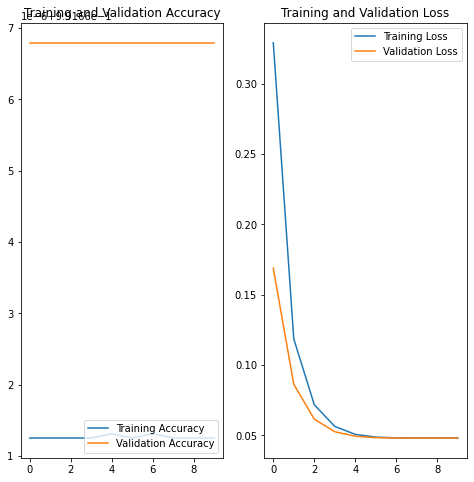

In [80]:
acc = model_new.history.history['accuracy']
val_acc = model_new.history.history['val_accuracy']

loss = model_new.history.history['loss']
val_loss = model_new.history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
# tf.saved_model.save(model_new, "/tmp/mobilenet/5/")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/mobilenet/5/assets


In [82]:
# loaded = tf.saved_model.load("/tmp/mobilenet/5/")
tf.keras.models.save_model(model_new,"/tmp/mobilenet/7/8")
# print("MobileNet has {} trainable variables: {}, ...".format(
#           len(loaded.trainable_variables),
#           ", ".join([v.name for v in loaded.trainable_variables[:5]])))

INFO:tensorflow:Assets written to: /tmp/mobilenet/7/8/assets


In [83]:
!saved_model_cli show --dir {"/tmp/mobilenet/7/8"} --all

2020-03-28 10:51:54.798657: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-03-28 10:51:54.798824: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory
2020-03-28 10:51:54.798834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        nam

In [46]:
loaded = tf.saved_model.load("/tmp/mobilenet/7/7")
print(list(loaded.signatures.keys()))  # ["serving_default"]
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)
#imagenet_labels = np.array(open(label_name).read().splitlines())

labeling = infer(tf.constant(x))[pretrained_model.output_names[0]]

decoded = label_name[np.argsort(labeling)[0,::-1][:5]+1]

print("Result after saving and loading:\n", decoded)

['serving_default']
{'dense_5': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense_5')}


TypeError: expected str, bytes or os.PathLike object, not list

In [73]:
pre_data[0].shape

TensorShape([100, 100, 3])

In [85]:
import json
import numpy
import requests

test_image1 = "/root/quan/fruits-360/papers/87761.jpg"
ts = "/root/quan/fruits-360/Training/Banana/0_100.jpg"
test_image = tf.io.read_file(ts)
test_wb = decode_img(test_image)
dfp =np.resize(pre_data[0].numpy(), [1,80,80,3])
data = json.dumps({"signature_name": "serving_default",
                   "instances": dfp.tolist()})

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/mobilenet1:predict',
                              data=data, headers=headers)
print(json_response.text)
predictions = numpy.array(json.loads(json_response.text)["predictions"])

#predictions = predictions*100
predictions[0]

{
    "predictions": [[-4.77908]
    ]
}


array([-4.77908])

In [70]:
np.argmax(predictions[0])

0

In [54]:
label_name[4]   

'Apple Golden 3'